GPUs detected and memory growth enabled.
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best RF parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Random Forest - MSE: 0.6333, MAE: 0.3939, R²: 0.9992
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best XGB parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
XGBoost - MSE: 1.0622, MAE: 0.7256, R²: 0.9987
Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 629ms/step - loss: 3331.0183 - mae: 49.6826 - val_loss: 3392.3682 - val_mae: 50.6850 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3324.2739 - mae: 50.1723 - val_loss: 3368.4312 - val_mae: 50.6287 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3203.1882 - mae: 49.8688 - val_loss: 3343.0137 - val_mae: 50.6380 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3152.4116 - mae: 49.9366

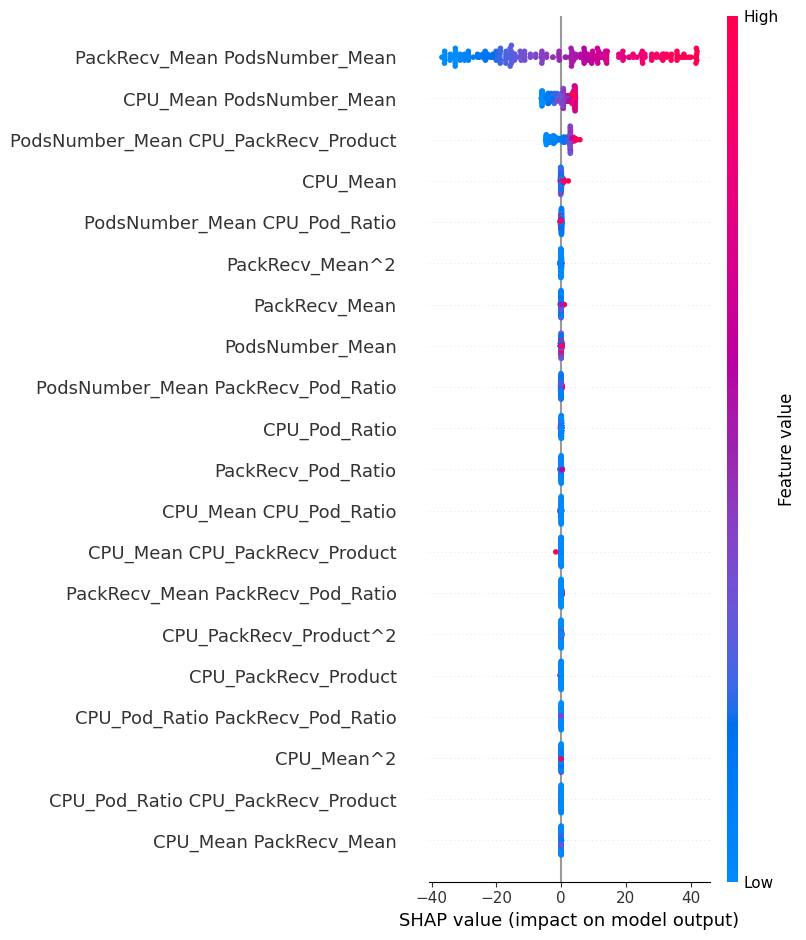

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
Predicted Stress Level: 131.22
Status: Critical stress
Confidence: 0.65
Best model is RandomForest with R² score: 0.9992


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

# Enable GPU memory growth (ensuring Kaggle GPU is utilized)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPUs detected and memory growth enabled.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected.")

# Enable mixed precision for better GPU utilization
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the datasets
train_data = pd.read_csv('/kaggle/input/k8-predection/TrainData.csv')
test_k8s_data = pd.read_csv('/kaggle/input/k8-predection/TestK8sData.csv')
test_jmeter_data = pd.read_csv('/kaggle/input/k8-predection/TestJMeterData.csv')

# Convert timestamp to datetime in test_k8s_data
test_k8s_data['Timestamp'] = pd.to_datetime(test_k8s_data['Timestamp'], format='%d-%b-%Y %H:%M:%S')
test_k8s_data['Duration'] = pd.to_timedelta(test_k8s_data['Duration'])
test_k8s_data['Duration_Seconds'] = test_k8s_data['Duration'].dt.total_seconds()

# Enhanced feature engineering
# Create base features
X = train_data[['CPU_Mean', 'PackRecv_Mean', 'PodsNumber_Mean']]
y = train_data['StressRate_Mean']

# Create interaction features
X['CPU_Pod_Ratio'] = X['CPU_Mean'] / (X['PodsNumber_Mean'] + 0.1)  # Avoid division by zero
X['PackRecv_Pod_Ratio'] = X['PackRecv_Mean'] / (X['PodsNumber_Mean'] + 0.1)
X['CPU_PackRecv_Product'] = X['CPU_Mean'] * X['PackRecv_Mean']

# Apply polynomial features (degree 2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Create tf.data.Dataset for more efficient GPU utilization
BATCH_SIZE = 128  # Increased from 32
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val_scaled, y_val))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Create time-based features for test data
test_k8s_data['Hour'] = test_k8s_data['Timestamp'].dt.hour
test_k8s_data['Minute'] = test_k8s_data['Timestamp'].dt.minute
test_k8s_data['Second'] = test_k8s_data['Timestamp'].dt.second

# Create rolling window features with more sophisticated analysis
test_features = []
for (exp, stress, init_pods), group in test_k8s_data.groupby(['Experiment', 'StressUpRate', 'InitialPodsNumber']):
    group = group.sort_values('Duration_Seconds')
    # Calculate rolling statistics with multiple window sizes
    for window in [3, 5, 10]:
        group[f'CPU_Rolling_Mean_{window}s'] = group['CPU'].rolling(window=window, min_periods=1).mean()
        group[f'CPU_Rolling_Std_{window}s'] = group['CPU'].rolling(window=window, min_periods=1).std().fillna(0)
        group[f'PackRecv_Rolling_Mean_{window}s'] = group['PackRecv'].rolling(window=window, min_periods=1).mean()
        group[f'PackRecv_Rolling_Std_{window}s'] = group['PackRecv'].rolling(window=window, min_periods=1).std().fillna(0)
    # Calculate rate of change and acceleration
    group['CPU_Rate_of_Change'] = group['CPU'].diff().fillna(0)
    group['PackRecv_Rate_of_Change'] = group['PackRecv'].diff().fillna(0)
    group['CPU_Acceleration'] = group['CPU_Rate_of_Change'].diff().fillna(0)
    group['PackRecv_Acceleration'] = group['PackRecv_Rate_of_Change'].diff().fillna(0)
    # Add exponential weighted features
    group['CPU_EWM'] = group['CPU'].ewm(span=5).mean()
    group['PackRecv_EWM'] = group['PackRecv'].ewm(span=5).mean()
    test_features.append(group)

test_features_df = pd.concat(test_features)

##############################################
# Model Training & Evaluation
##############################################

# Hyperparameter tuning for Random Forest
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_grid = GridSearchCV(rf_model, rf_params, cv=3, n_jobs=-1, verbose=1)
rf_grid.fit(X_train_scaled, y_train)
best_rf_model = rf_grid.best_estimator_
print(f"Best RF parameters: {rf_grid.best_params_}")

y_pred_rf = best_rf_model.predict(X_val_scaled)
mse_rf = mean_squared_error(y_val, y_pred_rf)
mae_rf = mean_absolute_error(y_val, y_pred_rf)
r2_rf = r2_score(y_val, y_pred_rf)
print(f"Random Forest - MSE: {mse_rf:.4f}, MAE: {mae_rf:.4f}, R²: {r2_rf:.4f}")

# Hyperparameter tuning for XGBoost (utilizing GPU)
xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.7, 0.9]
}
xgb_model = xgb.XGBRegressor(random_state=42, tree_method='gpu_hist')
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=3, n_jobs=-1, verbose=1)
xgb_grid.fit(X_train_scaled, y_train)
best_xgb_model = xgb_grid.best_estimator_
print(f"Best XGB parameters: {xgb_grid.best_params_}")

y_pred_xgb = best_xgb_model.predict(X_val_scaled)
mse_xgb = mean_squared_error(y_val, y_pred_xgb)
mae_xgb = mean_absolute_error(y_val, y_pred_xgb)
r2_xgb = r2_score(y_val, y_pred_xgb)
print(f"XGBoost - MSE: {mse_xgb:.4f}, MAE: {mae_xgb:.4f}, R²: {r2_xgb:.4f}")

# Enhanced Neural Network model (will utilize GPU automatically)
def create_enhanced_nn_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dense(1)
    ])
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

nn_model = create_enhanced_nn_model(X_train_scaled.shape[1])
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
history = nn_model.fit(train_dataset, validation_data=val_dataset, epochs=200, callbacks=[early_stopping, reduce_lr], verbose=1)
y_pred_nn = nn_model.predict(X_val_scaled).flatten()
mse_nn = mean_squared_error(y_val, y_pred_nn)
mae_nn = mean_absolute_error(y_val, y_pred_nn)
r2_nn = r2_score(y_val, y_pred_nn)
print(f"Neural Network - MSE: {mse_nn:.4f}, MAE: {mae_nn:.4f}, R²: {r2_nn:.4f}")

# Ensemble model (average predictions)
def ensemble_predict(models, X):
    predictions = np.column_stack([model.predict(X) for model in models])
    return np.mean(predictions, axis=1)
ensemble_models = [best_rf_model, best_xgb_model]
y_pred_ensemble = ensemble_predict([best_rf_model, best_xgb_model, nn_model], X_val_scaled)
mse_ensemble = mean_squared_error(y_val, y_pred_ensemble)
mae_ensemble = mean_absolute_error(y_val, y_pred_ensemble)
r2_ensemble = r2_score(y_val, y_pred_ensemble)
print(f"Ensemble - MSE: {mse_ensemble:.4f}, MAE: {mae_ensemble:.4f}, R²: {r2_ensemble:.4f}")

##############################################
# Innovation: Autoencoder for Anomaly Detection
##############################################
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

def create_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    # Encoder
    encoded = Dense(64, activation='relu')(input_layer)
    encoded = Dense(32, activation='relu')(encoded)
    encoded = Dense(16, activation='relu')(encoded)
    # Decoder
    decoded = Dense(32, activation='relu')(encoded)
    decoded = Dense(64, activation='relu')(decoded)
    output_layer = Dense(input_dim, activation='linear')(decoded)
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

autoencoder = create_autoencoder(X_train_scaled.shape[1])
autoencoder.fit(X_train_scaled, X_train_scaled, epochs=50, batch_size=128,
                validation_data=(X_val_scaled, X_val_scaled), verbose=1)
reconstructions = autoencoder.predict(X_val_scaled)
reconstruction_error = np.mean(np.square(X_val_scaled - reconstructions), axis=1)
error_threshold = np.mean(reconstruction_error) + 2 * np.std(reconstruction_error)
anomaly_flags = reconstruction_error > error_threshold
print("Autoencoder Anomaly Detection:")
print(f"Mean Reconstruction Error: {np.mean(reconstruction_error):.4f}")
print(f"Error Threshold: {error_threshold:.4f}")
print(f"Number of anomalies detected: {np.sum(anomaly_flags)}")

##############################################
# Innovation: SHAP Explainability for XGBoost
##############################################
import shap
explainer = shap.Explainer(best_xgb_model)
shap_values = explainer(X_val_scaled)
# Generate a summary plot (this will open a matplotlib window if run locally)
feature_names = poly.get_feature_names_out(['CPU_Mean', 'PackRecv_Mean', 'PodsNumber_Mean',
                                              'CPU_Pod_Ratio', 'PackRecv_Pod_Ratio', 'CPU_PackRecv_Product'])
shap.summary_plot(shap_values, X_val_scaled, feature_names=feature_names)

##############################################
# Improved Prediction Function for New Data
##############################################
def predict_stress_level(models, cpu, packet_recv, pods_number, scaler):
    """
    Predict stress level for given metrics using ensemble of models.
    Returns: Predicted stress level, status, and confidence.
    """
    input_data = pd.DataFrame({
        'CPU_Mean': [cpu],
        'PackRecv_Mean': [packet_recv],
        'PodsNumber_Mean': [pods_number]
    })
    input_data['CPU_Pod_Ratio'] = input_data['CPU_Mean'] / (input_data['PodsNumber_Mean'] + 0.1)
    input_data['PackRecv_Pod_Ratio'] = input_data['PackRecv_Mean'] / (input_data['PodsNumber_Mean'] + 0.1)
    input_data['CPU_PackRecv_Product'] = input_data['CPU_Mean'] * input_data['PackRecv_Mean']
    poly_local = PolynomialFeatures(degree=2, include_bias=False)
    input_poly = poly_local.fit_transform(input_data)
    scaled_input = scaler.transform(input_poly)
    predictions = []
    for model in models:
        pred = model.predict(scaled_input)
        if isinstance(pred, np.ndarray):
            pred = pred.flatten()[0]
        predictions.append(pred)
    prediction = np.mean(predictions)
    prediction_std = np.std(predictions)
    confidence = 1.0 - (prediction_std / prediction) if prediction > 0 else 0.0
    if prediction < 20:
        status = "Normal operation"
    elif prediction < 40:
        status = "Moderate stress"
    elif prediction < 60:
        status = "High stress"
    else:
        status = "Critical stress"
    return prediction, status, confidence

# Example usage of prediction function
cpu_input = 75.0
packet_recv_input = 120.5
pods_number_input = 10
predicted_stress, status, confidence = predict_stress_level(
    [best_rf_model, best_xgb_model, nn_model], 
    cpu_input, packet_recv_input, pods_number_input, scaler
)
print(f"Predicted Stress Level: {predicted_stress:.2f}")
print(f"Status: {status}")
print(f"Confidence: {confidence:.2f}")

##############################################
# Save the Best Performing Model (by R² accuracy)
##############################################
import joblib

performance_scores = {
    "RandomForest": r2_rf,
    "XGBoost": r2_xgb,
    "NeuralNetwork": r2_nn,
    "Ensemble": r2_ensemble
}
best_model_name = max(performance_scores, key=performance_scores.get)
best_model_score = performance_scores[best_model_name]
print(f"Best model is {best_model_name} with R² score: {best_model_score:.4f}")

# Save the model with a filename including its name and accuracy
if best_model_name == "RandomForest":
    joblib.dump(best_rf_model, f"best_model_{best_model_name}_{best_model_score:.4f}.pkl")
elif best_model_name == "XGBoost":
    joblib.dump(best_xgb_model, f"best_model_{best_model_name}_{best_model_score:.4f}.pkl")
elif best_model_name == "NeuralNetwork":
    nn_model.save(f"best_model_{best_model_name}_{best_model_score:.4f}.h5")
elif best_model_name == "Ensemble":
    # For ensemble, we save the list of models as a pipeline
    joblib.dump(ensemble_models, f"best_model_{best_model_name}_{best_model_score:.4f}.pkl")